In [3]:
import sys
sys.path.append("..")

In [4]:
import nltk, re, string, time, os
import pandas as pd
import numpy as np
# from textClassification import textAnalysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn import metrics 
from sklearn import cross_validation
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
%matplotlib inline

import operator
english_stopwords = stopwords.words('english')

### Helper functions

In [5]:
# automate creation of csv for kaggle submission
def create_submission(filename, prediction):
    pd.DataFrame.to_csv(pd.DataFrame(df_test['Id']).join(pd.DataFrame(prediction)), path_or_buf=filename, header=['Id','Category'], index=False)

In [7]:
# automate crossvalidation and printing of results
def crossvalidation(model, train_features, real_category):
    scores = cross_validation.cross_val_score(model, train_features, real_category, cv=5)
    print("Accuracy: %0.5f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

## Loading Data

In [8]:
df = pd.read_csv("newtrain.csv", low_memory=False)

In [9]:
df_test = pd.read_csv("newtest.csv", low_memory=False)

## Prepping data

In [10]:
cat_dict = dict()

In [11]:
cat_dict = {1:"Business&Finance",2:"Computers&Internet",3:"Entertainment&Music",4:"Family&Relationships",5:"Education&Reference",6:"Health",7:"Science&Mathematics"}

In [10]:
# creating feature for lengths of text and converting to pandas series
lengths = []
for i in df.Text.iteritems():
    lengths.append(len(i[1]))
lengths = pd.Series(lengths)

In [11]:
# appending lengths feature to dataframe
df['lengths'] = lengths

## Implementation and Testing of Strategies

###Creating 'Predict Function' to test subsequent strategies

In [16]:
# function to facilitate testing of variations in CountVecotrizer parameters (min_df, max_features, etc.)
def Predict(model, vec, train_set, other_set, scoring, num_neighbors=1):
    '''
    model -  LogisticRegression, MultinomialNB, KNeighborsClassifier, svm
    '''
    # Train-data sparce vectorizing
    arr_train_feature_sparse = vec.fit_transform(train_set.Text)
    arr_train_feature = arr_train_feature_sparse.toarray()
    print("arr_train_feature.shape:", arr_train_feature.shape)

    # Other data sparce vectorizing
    arr_other_feature_sparse = vec.transform(other_set.Text)
    arr_other_feature = arr_other_feature_sparse.toarray()
    print("arr_other_feature.shape:", arr_other_feature.shape,'\n')

    # Training model with features in sparce array (arr_train_feature) and labels (df.Category)
    if model == KNeighborsClassifier:
        nb = model(n_neighbors = num_neighbors)
    else:
        nb = model
        
    nb_model_train = nb.fit(arr_train_feature, train_set.Category)    

    # predicting against dev features in sparce array
    nb_predictions_other = nb_model_train.predict(arr_other_feature)
    
    # print out crossvalidation or scoring results
    if scoring == 'cv':
        crossvalidation(nb, arr_train_feature, train_set.Category)
    elif scoring == 'score': 
        print(accuracy_score(other_set.Category, nb_predictions_other))
        
    return nb_predictions_other

In [ ]:
create_submission('submission_6.csv', tfid_test_predictions)

### Proper Nouns

**develop training, dev, testing sets**

In [29]:
random_index = np.random.permutation(df.index)
df_shuffled = df.ix[random_index]
df_shuffled.reset_index(drop=True, inplace=True)
df_shuffled[:5]

,Category,Text
0,3,when will the new episodes of justice league u...
1,3,i dreamed that i am undressed in public
2,3,a simple riddle? what goes through a door but ...
3,1,what is the genesis of the name 401k?
4,3,what is worse than biting an apple &amp; seein...


In [30]:
rows, columns = df_shuffled.shape
print("Rows:", rows)
print("Columns:", columns)

Rows: 2698
Columns: 2


**80/20 split for training/ dev**

In [31]:
train_size = round(rows*.8)
dev_size   = round(rows*.2)

In [32]:
df_train = df_shuffled.loc[:train_size]
print('train:',df_train.shape)

df_dev = df_shuffled.loc[train_size:dev_size+train_size].reset_index(drop=True)
print('dev:',df_dev.shape)

train: (2159, 2)
dev: (540, 2)


##Implement voting system between models

In [33]:
def vote_winner(pair):
    dic = {}
    for i in range(len(pair)):
        num = pair[i]
        if num in dic:
            dic[num] += 1
        else:
            dic[num] = 1
    return sorted(dic.items(), key=operator.itemgetter(1), reverse=True)[0][0]
     

## counting # of "I"
**Training**

In [34]:
tok_sent_train = []
for i in df_train.Text:
    tok_sent_train.append(nltk.word_tokenize(i))
    
num_i_train = []
for i in tok_sent_train:
    count = 0
    for j in i:
        if j == "i":
            count += 1
    num_i_train.append(count)
    
# num_i = pd.Series(num_i)
# df_train['num_i'] = num_i

df_train_features = pd.DataFrame(num_i_train, columns=['num_i'])

vec_count = tfidf_vec = TfidfVectorizer(min_df=1, max_features=1000)
arr_train_feature_sparse = vec_count.fit_transform(df_train.Text)
arr_train_features = arr_train_feature_sparse.toarray()
df_train_features = df_train_features.join(pd.DataFrame(arr_train_features))

**Dev**

In [35]:
tok_sent_dev = []
for i in df_dev.Text:
    tok_sent_dev.append(nltk.word_tokenize(i))
    
num_i_dev = []
for i in tok_sent_dev:
    count = 0
    for j in i:
        if j == "i":
            count += 1
    num_i_dev.append(count)
    
# num_i_dev = pd.Series(num_i)
# df_dev['num_i'] = num_i


df_dev_features = pd.DataFrame(num_i_dev, columns=['num_i'])

In [36]:
df_dev_features.head()

,num_i
0,0
1,0
2,0
3,1
4,0


In [37]:
arr_dev_features = tfidf_vec.transform(df_dev.Text)
df_dev_features = df_dev_features.join(pd.DataFrame(arr_dev_features.toarray()))

In [38]:
df_dev_features.shape

(540, 1001)

In [39]:
nb = MultinomialNB()
nb_model = nb.fit(df_train_features, df_train.Category)
nb_predictions = nb_model.predict(df_dev_features)
nb_predictions[:10]

array([1, 4, 2, 1, 1, 1, 1, 1, 1, 2])

In [40]:
accuracy_score(df_dev.Category, nb_predictions)

0.45925925925925926

In [41]:
crossvalidation(nb_model, df_train_features, df_train.Category)

Accuracy: 0.43443 (+/- 0.03)



##TFIDF

In [42]:
tfidf_vec = TfidfVectorizer(min_df=1, max_features=1190, stop_words='english')
nb = MultinomialNB(alpha=0.9, class_prior=None, fit_prior=False)
dev_predictions_nb = Predict(nb, tfidf_vec, df_train, df_dev, 'score')
test_predictions_nb = Predict(nb, tfidf_vec, df, df_test, 'cv')
train_predictions_nb = Predict(nb, tfidf_vec, df, df, 'cv')

In [115]:
create_submission("submission_8.csv", test_predictions)

## Analyzing Confusion Matrix

In [55]:
train_predictions_svm = Predict(svm_model, tfidf_vec, df_train, df_train, 'cv')
train_predictions_svm.shape

arr_train_feature.shape: (2159, 1190)
arr_other_feature.shape: (2159, 1190) 

Accuracy: 0.49744 (+/- 0.02)



(2159,)

In [56]:
# Credit to Marti H. And John S. for the following function and the confusion matrix plotting code:

def plot_confusion_matrix(cm, title, target_names, cmap=plt.cm.coolwarm):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [57]:
class_labels = np.sort(df_train.Category.unique())

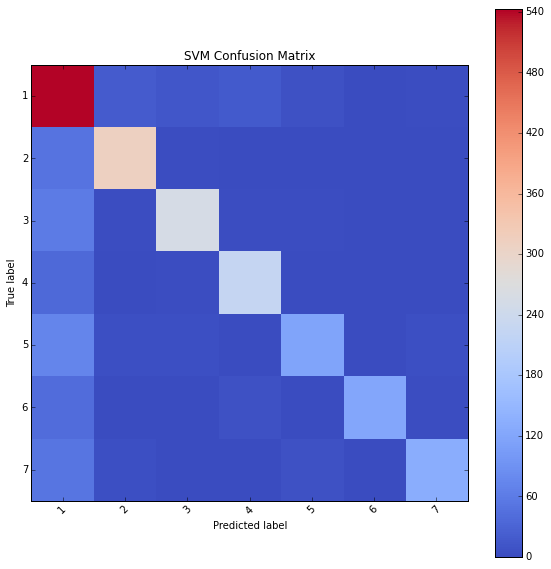

In [58]:
nb_cm = confusion_matrix(df_train.Category, train_predictions_svm)
plot_confusion_matrix(nb_cm, "SVM Confusion Matrix", class_labels)

In [59]:
pd.crosstab(df_train.Category, train_predictions_svm, 
            rownames=['True'], colnames=['Predicted'], 
            margins=True)

Predicted,1,2,3,4,5,6,7,All
True,,,,,,,,
1,543,21,13,18,7,0,3,605
2,49,311,3,1,1,0,2,367
3,61,3,256,4,3,1,1,329
4,37,1,3,226,0,2,2,271
5,73,5,5,0,117,1,5,206
6,41,1,2,8,1,121,3,177
7,52,6,2,2,8,2,132,204
All,856,348,284,259,137,127,148,2159
